### Testing the MDiN Functions - Added to Data Augmentation Repository since it is not in the paper_sMDiN.

This notebooks compares Simple MDiN Function to the MDiNs made from Cytoscape MetaNetter and test Univocal and Formula MDiNs.

Organization of the notebook:

- Read Datasets and MDiNs built with those datasets in Cytoscape (using MetaNetter).
- Build MDiNs with the scripts developed.
- Compare those MDiNs with MDiNs from MetaNetter

**Needed Imports**

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns
import networkx as nx

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse
import json

import MDiN_functions as md

Read the datasets

In [2]:
# Where the datasets are
path = Path.cwd() / "store_data" / 'processed_data.json'
storepath = Path.cwd() / "store_data" / 'processed_data.h5'
with pd.HDFStore(storepath) as store:
    
    # Read into a dictionary not DataFrame data
    with open(path, encoding='utf8') as read_file:
        datasets = json.load(read_file)
    
    # Add DataFrame data to dict
    for dskey, dataset in datasets.items():
        dataset['iter_fold_splits'] = {}
        if dskey == 'HD':
            dataset['train'] = {}
            dataset['test'] = {}
        for key in dataset:
            # Created right before
            if 'iter_fold_splits' == key:
                continue
            value = dataset[key]
            if isinstance(value, str) and value.startswith("INSTORE"):
                storekey = value.split("_", 1)[1]
                #print(storekey)
                # Load the data from 'iter_fold_splits' carefully restoring the nested dictionaries
                if len(storekey.split("AA_")) > 1: # This separation was made to identify the 'iter_fold_splits' data
                    dictkeys = (storekey.split("AA_")[1]).split('_',3)
                    # Create nested dicts
                    if int(dictkeys[0]) not in dataset['iter_fold_splits'].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])] = {}
                    if dictkeys[1] not in dataset['iter_fold_splits'][int(dictkeys[0])].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]] = {}
                    if int(dictkeys[2]) not in dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])] = {}
                    dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])][dictkeys[3]] = store[storekey]
                
                # Load the data from 'train' and 'test' from HD dataset keys carefully restoring the nested dictionaries
                elif len(storekey.split("TTS_")) > 1:
                    dictkeys = ((storekey.split("TTS_")[0]).split('_')[-1], storekey.split("TTS_")[1])#.split('_',2)
                    dataset[dictkeys[0]][dictkeys[1]] = store[storekey]
                # Normal DataFrames
                else:
                    dataset[key] = store[storekey]

            # convert colors to tuples, since they are read as lists from json file
            elif key == 'label_colors':
                dataset[key] = {lbl: tuple(c) for lbl, c in value.items()}
            elif key == 'sample_colors':
                dataset[key] = [tuple(c) for c in value]
            elif key.endswith('target') and key.startswith(dskey):
                if len(key.split("AA_")) > 1: 
                    dictkeys = ((key.split("_", 1)[1]).split("AA_")[1]).split('_',3)
                    dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])][dictkeys[3]] = value
                else:
                    dictkeys = ((key.split("TTS_")[0]).split('_')[-1], key.split("TTS_")[1])#.split('_',2)
                    dataset[dictkeys[0]][dictkeys[1]] = value

# Remove extra keys
for name, ds in datasets.items():
    keys_to_remove = [keys for keys in ds.keys() if keys.startswith(name)]
    for key in keys_to_remove:
        ds.pop(key)


In [3]:
datasets.pop('YD2')
datasets.pop('GD_pos_class2')
datasets.pop('GD_pos_global2')
datasets.keys()

dict_keys(['GD_neg_global2', 'GD_neg_class2', 'YD', 'vitis_types'])

### Build and Read the Mass-Difference Networks in Cytoscape using MetaNetter 2.0

To build the network in Cytoscape we need:

1) A list of neutral masses (with masses as float in node attributes).

2) A list of allowed transformations with specific mass differences - list of MDBs built see quick list below or see transgroups.txt file for more detail.

The transformation files and the dataset files were built in `paper_sMDiNs_database_prep.ipynb` and used in Cytoscape to build the MDiNs.

Parameters: 1 ppm error allowed for edge establishment.

The Yeast datasets already have the m/z 'buckets' that are already representing the neutral masses of the metabolites. To consider the neutral masses of the grapevine datasets, a simple transformation by adding or removing a proton (Hydrogen atom mass - electron mass), depending if the ionization mode is negative or positive, respectively, on the m/z peaks was made.

Only one full network (for each benchmark dataset) is built. Then, subgraphs of them will be used to select every sample MDiN. This is the same as building an MDiN for each sample.

The networks were exported in graphml format that networkX module can read.

- Nodes have a standard number ID instead of the mass (stored as the attribute 'mass'). Other attributes stored are irrelevant. 
- Edges among the different attributes have a very useful attribute called 'Transformation' which stores which MDB of the list was used to establish the edge - will be used for MDB Impact analysis.
- Finally, the graph is directed. Since reactions are bidireccional, they will be transformed to undirected graphs.

Changes that will be made to the network:

- Nodes will be identified by their masses.

In [4]:
# Chemical Formula transformations (MDBs chosen)
MDB = ['H2','CH2','CO2','O','CH2O','NCH','O(N-H-)','S','CONH','PO3H','NH3(O-)','SO3','CO', 'C2H2O', 'H2O']
MDB_YD = ['H2','CH2','CO2','O','CH2OH','NCH','O(N-H-)','S','CONH','PO3H','NH3(O-)','SO3','CO', 'C2H2O', 'H2O', 
          'C2H2O2', 'C3H4O2']

In [5]:
# Read the MDiNs built using Cytoscape's MetaNetter
for name, ds in datasets.items():
    print(f'Reading MDiN based on data in {name}', end=' ...')
    MDiN_temp = nx.read_graphml('mass_data/MassList' + name +'.graphml')
    
    # Making dicts for the new names
    new_nodes = dict.fromkeys(MDiN_temp.nodes(),0)

    for i,mz in nx.get_node_attributes(MDiN_temp,'mass').items(): # i is old name, mz is mass/new name
        new_nodes[i] = mz

    # Relabeling nodes
    MDiN_temp = nx.relabel_nodes(MDiN_temp, mapping=new_nodes)
    
    ds['MDiN'] = MDiN_temp.to_undirected()
    print('done!')

Reading MDiN based on data in GD_neg_global2 ...done!
Reading MDiN based on data in GD_neg_class2 ...done!
Reading MDiN based on data in YD ...done!
Reading MDiN based on data in vitis_types ...done!


### Building MDiNs using Python Script - Normal/Simple equal to Metanetter and Univocal

There are 3 methods to build MDiNs from the Python scripts made that sequentially evolve in complexity and time to build.

- Simple MDiNs - this is the normal form of MDiNs where an edge is made between all peaks m/z whose mass-difference is equal to one of the MDBs in the list of chemical transformations accepted (within a margin of error given). This means that a peak may connect to two very similar peaks in terms of mass by the same  MDB (in the same direction, addition or subtraction), that is, they would correspond to the same compound or to isomers which should be represented by a single mass peak.

- Univocal MDiNs - this is an upgraded version of the previous in the sense that when a peak connects to two very similar mass peaks, one of these edges is then removed (the edge with the higher associated error).

- Formula MDiNs - this method picks up a Univocal MDiN and uses it for formula propagation and annotation. Here, a set of reliable formula annotations function as the starting point and propogate. If there is conflict between the formula propagation, at least one edge is removed to ensure that the network in itself makes sense, gaining internal consistency.

In [6]:
# Setting up the Chemical Transformations DataFrame for most MDiNs (sinalizing the differences in formula each lead to)
tg = pd.read_csv('transgroups.txt', sep='\t', header=None)
tg.columns = ['Label', 'Transformation', 'Mass', 'Selected']
tg = tg.set_index('Label')

comp = []
for i in tg.index:
    comp.append(md.formula_process(i))
tg['Comp.'] = comp

# Setting up the Chemical Transformations DataFrame for YD MDiN
tg_YD = pd.read_csv('transgroups_YD.txt', sep='\t', header=None)
tg_YD.columns = ['Label', 'Transformation', 'Mass', 'Selected']
tg_YD = tg_YD.set_index('Label')
comp = []
for i in tg_YD.index:
    comp.append(md.formula_process(i))
tg_YD['Comp.'] = comp

tg_YD

,Transformation,Mass,Selected,Comp.
Label,,,,
O(N-H-),Deamination,0.984016,True,"{'C': 0, 'H': -1, 'O': 1, 'N': -1, 'S': 0, 'P'..."
NH3(O-),Transamination,1.031634,True,"{'C': 0, 'H': 3, 'O': -1, 'N': 1, 'S': 0, 'P':..."
H2,Hydrogenation,2.015650,True,"{'C': 0, 'H': 2, 'O': 0, 'N': 0, 'S': 0, 'P': ..."
CH2,Methylation,14.015650,True,"{'C': 1, 'H': 2, 'O': 0, 'N': 0, 'S': 0, 'P': ..."
O,Oxygenation,15.994915,True,"{'C': 0, 'H': 0, 'O': 1, 'N': 0, 'S': 0, 'P': ..."
H2O,Condensation/Dehydration/Cyclization,18.010565,True,"{'C': 0, 'H': 2, 'O': 1, 'N': 0, 'S': 0, 'P': ..."
NCH,Formidoylation,27.010899,True,"{'C': 1, 'H': 1, 'O': 0, 'N': 1, 'S': 0, 'P': ..."
CO,Formylation,27.994915,True,"{'C': 1, 'H': 0, 'O': 1, 'N': 0, 'S': 0, 'P': ..."
CHOH,Hydroxymethylation,30.010565,True,"{'C': 1, 'H': 1, 'O': 1, 'N': 0, 'S': 0, 'P': ..."


In [7]:
graphs = dict.fromkeys(datasets.keys())

# Build the MDiNs built using our Python Function
for name, ds in datasets.items():
    print(f'Building MDiN based on data in {name}', end=' ...')
    if name == 'YD':
        transf_gr = tg_YD
    else:
        transf_gr = tg
        
    # Simple MDiNs
    gr = md.simple_MDiN(list(ds['MDiN'].nodes()), trans_groups=transf_gr, ppm=1)

    # Univocal MDiNs
    gr_uni = md.univocal_MDiN(list(ds['MDiN'].nodes()), trans_groups=transf_gr, ppm=1)

    graphs[name] = {'MetaNetter': ds['MDiN'], 'SimpleMDiN': gr, 'UnivocalMDiN': gr_uni}
    print('done!')


#graph = md.simple_MDiN(list(datasets['YD']['MDiN'].nodes()), trans_groups=tg_YD, ppm=1)

Building MDiN based on data in GD_neg_global2 ...done!
Building MDiN based on data in GD_neg_class2 ...done!
Building MDiN based on data in YD ...done!
Building MDiN based on data in vitis_types ...done!


In [8]:
# Analyze graph characteristics of the networks built
Net_Chara = pd.DataFrame(columns=['# Nodes', '# Edges', 'Biggest Comp. Size', 'Connected Nodes', 
                                  'Diameter', 'Radius'])
Net_Chara = pd.DataFrame(columns=['# Nodes', '# Edges', 'Biggest Comp. Size', 'Connected Nodes'])

for name, ds in graphs.items():
    # MetaNetter MDiN
    Net_Chara.loc[name + '_MetaNetter', '# Nodes'] = len(ds['MetaNetter'].nodes())
    Net_Chara.loc[name + '_MetaNetter', '# Edges'] = len(ds['MetaNetter'].edges())
    
    Main_component = ds['MetaNetter'].subgraph(list(sorted(nx.connected_components(ds['MetaNetter']), key=len, reverse=True)[0]))
    Net_Chara.loc[name + '_MetaNetter', 'Biggest Comp. Size'] = len(Main_component.nodes())
    
    isolated = 0
    for node in ds['MetaNetter'].degree():
        if node[1] == 0:
            isolated = isolated + 1
    Net_Chara.loc[name + '_MetaNetter', 'Connected Nodes'] = (len(ds['MetaNetter'].nodes()) - isolated) / len(ds['MetaNetter'].nodes()) * 100

    # Simple/Normal MDiN
    Net_Chara.loc[name + '_Simple', '# Nodes'] = len(ds['SimpleMDiN'].nodes())
    Net_Chara.loc[name + '_Simple', '# Edges'] = len(ds['SimpleMDiN'].edges())
    
    Main_component = ds['SimpleMDiN'].subgraph(list(sorted(nx.connected_components(ds['SimpleMDiN']), key=len, reverse=True)[0]))
    Net_Chara.loc[name + '_Simple', 'Biggest Comp. Size'] = len(Main_component.nodes())
    
    isolated = 0
    for node in ds['SimpleMDiN'].degree():
        if node[1] == 0:
            isolated = isolated + 1
    Net_Chara.loc[name + '_Simple', 'Connected Nodes'] = (len(ds['SimpleMDiN'].nodes()) - isolated) / len(ds['SimpleMDiN'].nodes()) * 100

    # Univocal MDiN
    Net_Chara.loc[name + '_Univocal', '# Nodes'] = len(ds['UnivocalMDiN'].nodes())
    Net_Chara.loc[name + '_Univocal', '# Edges'] = len(ds['UnivocalMDiN'].edges())
    
    Main_component = ds['UnivocalMDiN'].subgraph(list(sorted(nx.connected_components(ds['UnivocalMDiN']), key=len, reverse=True)[0]))
    Net_Chara.loc[name + '_Univocal', 'Biggest Comp. Size'] = len(Main_component.nodes())
    
    isolated = 0
    for node in ds['UnivocalMDiN'].degree():
        if node[1] == 0:
            isolated = isolated + 1
    Net_Chara.loc[name + '_Univocal', 'Connected Nodes'] = (len(ds['UnivocalMDiN'].nodes()) - isolated) / len(ds['UnivocalMDiN'].nodes()) * 100

In [9]:
# Compare for the 5 datasets, characteristics of the MetaNetter, Simple and Univocal MDiNs
Net_Chara

,# Nodes,# Edges,Biggest Comp. Size,Connected Nodes
GD_neg_global2_MetaNetter,3629,1044,187,32.488289
GD_neg_global2_Simple,3629,1044,187,32.488289
GD_neg_global2_Univocal,3629,852,71,30.97272
GD_neg_class2_MetaNetter,3026,754,160,29.543952
GD_neg_class2_Simple,3026,754,160,29.543952
GD_neg_class2_Univocal,3026,629,69,27.759418
YD_MetaNetter,1893,987,319,37.400951
YD_Simple,1893,987,319,37.400951
YD_Univocal,1893,953,308,36.872689
vitis_types_MetaNetter,3026,754,160,29.543952


In [10]:
for name, ds in graphs.items():
    #print(ds)
    a=0
    e_mn = list(ds['MetaNetter'].edges())
    e_sp = list(ds['SimpleMDiN'].edges())
    for i in e_mn:
        if i in e_sp:
            a +=1
    p = a/len(e_mn) *100
    edges = len(e_mn)
    print(f'Dataset {name} has {a} edges in common between MetaNetter and SimpleMDiN from a total of {edges}, that is {p}%.')
        

Dataset GD_neg_global2 has 1044 edges in common between MetaNetter and SimpleMDiN from a total of 1044, that is 100.0%.
Dataset GD_neg_class2 has 754 edges in common between MetaNetter and SimpleMDiN from a total of 754, that is 100.0%.
Dataset YD has 987 edges in common between MetaNetter and SimpleMDiN from a total of 987, that is 100.0%.
Dataset vitis_types has 754 edges in common between MetaNetter and SimpleMDiN from a total of 754, that is 100.0%.


### Building MDiNs using Python Script - Formula MDiNs

Formula MDiNs should be the best of the three options available. However, they are also the slowest and require prior metabolite/formula annotation as a starting point for formula annotation.

Thus, we only used the 'YD' dataset for this part since it is the only of these datasets to have prior metabolite annotation.

Read a file with the masses and corresponding annotaned Formulas (and Compound Names) to use as the set of starting formulas for formula propagation in the YD dataset and MDiN.

In [11]:
# Reading a file with yd_masses and the formulas associated.
yd_masses = pd.read_csv('YD_masses.csv').set_index('Unnamed: 0').T

# Only keep peaks below 1000 m/z - Very few peaks above 1000 m/z.
yd_masses = yd_masses.T[yd_masses.columns < 1000]
yd_masses = yd_masses.loc[yd_masses['Name'].dropna().index]
yd_masses

,m/z,Name,Formula
Unnamed: 0,,,
307.083818,308.0911,Glutathione,C10H17N3O6S
555.269298,556.27657,Enkephalin L,C28H37N5O7
493.316816,494.3241,PC_16:1_9Z_0:0_,C24H48NO7P
257.102875,258.11016,Glycerophosphocholine,C8H20NO6P
347.063081,348.07036,Adenosine monophosphate,C10H14N5O7P
...,...,...,...
916.507669,917.51495,1-MLCL_0:0_10:0_10:0_14:1_9Z_,C43H82O16P2
550.163642,551.17092,Castavinol C3,C26H30O13
914.598352,915.60563,PGP_10:0_30:0_,C46H92O13P2


Building Formula MDiN

In [12]:
#graph = md.simple_MDiN(list(datasets['YD']['MDiN'].nodes()), trans_groups=tg, ppm=1)
graph = md.formula_MDiN(list(datasets['YD']['MDiN'].nodes()), yd_masses, trans_groups=tg_YD, ppm=1)

Characteristics of the Formula MDiN built

In [13]:
print("The number of edges of YD's Formula MDiN is:", len(graph.edges()))

The number of edges of YD's Formula MDiN is: 907


In [14]:
Main_component = graph.subgraph(list(sorted(nx.connected_components(graph), key=len, reverse=True)[0]))
print('Size of the main component:', len(Main_component.nodes()))
#Net_Chara.loc[name, 'Diameter'] = nx.diameter(Main_component)
#Net_Chara.loc[name, 'Radius'] = nx.radius(Main_component)

isolated = 0
for node in graph.degree():
    if node[1] == 0:
        isolated = isolated + 1
print((len(graph.nodes()) - isolated) / len(graph.nodes()) * 100, '% of nodes are connected to at least one other node.')

Size of the main component: 272
36.13312202852615 % of nodes are connected to at least one other node.


#### Drawing Normal and Univocal MDiNs of GDg2

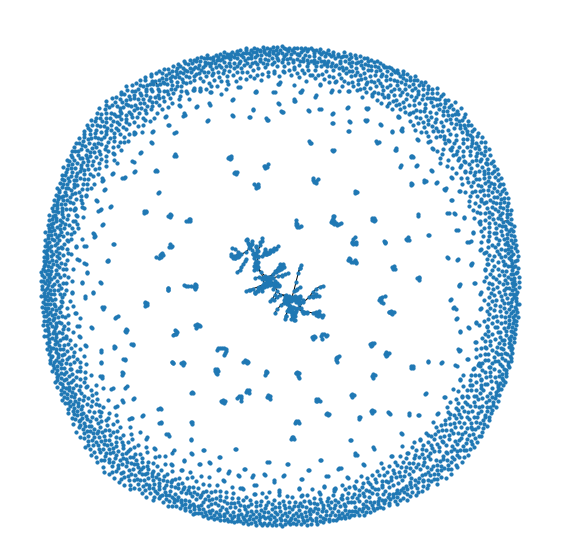

In [15]:
f, ax = plt.subplots(1,1, figsize=(10,10))
nx.draw(graphs['GD_neg_global2']['SimpleMDiN'], node_size=10)

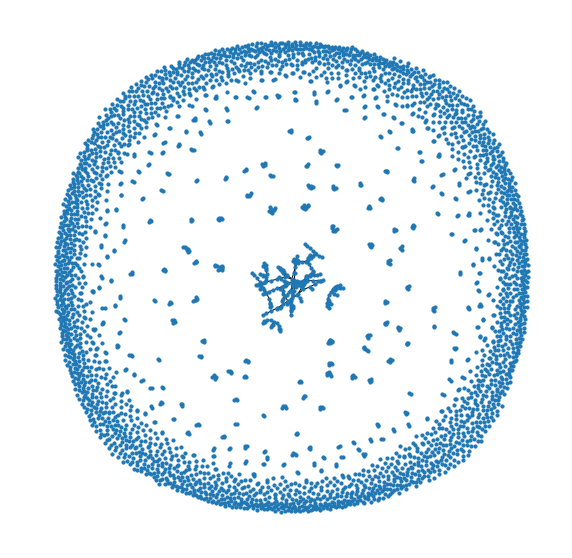

In [16]:
f, ax = plt.subplots(1,1, figsize=(10,10))
nx.draw(graphs['GD_neg_global2']['UnivocalMDiN'], node_size=10)

In [17]:
a = 0
for j, i in nx.get_node_attributes(graph, 'Formula').items():
    #print(i)
    if i != None:
        a += 1
print(a)

408


In [18]:
yd_masses

,m/z,Name,Formula
Unnamed: 0,,,
307.083818,308.0911,Glutathione,C10H17N3O6S
555.269298,556.27657,Enkephalin L,C28H37N5O7
493.316816,494.3241,PC_16:1_9Z_0:0_,C24H48NO7P
257.102875,258.11016,Glycerophosphocholine,C8H20NO6P
347.063081,348.07036,Adenosine monophosphate,C10H14N5O7P
...,...,...,...
916.507669,917.51495,1-MLCL_0:0_10:0_10:0_14:1_9Z_,C43H82O16P2
550.163642,551.17092,Castavinol C3,C26H30O13
914.598352,915.60563,PGP_10:0_30:0_,C46H92O13P2
